# Inception 

In [1]:
import d2l
from mxnet import gluon, np, npx
from mxnet.gluon import nn
npx.set_np()

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=128, resize=96)

The inception block

In [2]:
class Inception(nn.Block):
    # c1 - c4 are the number of output channels for each layer in the path.
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Path 1 is a single 1 x 1 convolutional layer.
        self.p1_1 = nn.Conv2D(c1, kernel_size=1, activation='relu')
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3 convolutional layer.
        self.p2_1 = nn.Conv2D(c2[0], kernel_size=1, activation='relu')
        self.p2_2 = nn.Conv2D(c2[1], kernel_size=3, padding=1, activation='relu')
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5 convolutional layer.
        self.p3_1 = nn.Conv2D(c3[0], kernel_size=1, activation='relu')
        self.p3_2 = nn.Conv2D(c3[1], kernel_size=5, padding=2, activation='relu')
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1 convolutional layer.
        self.p4_1 = nn.MaxPool2D(pool_size=3, strides=1, padding=1)
        self.p4_2 = nn.Conv2D(c4, kernel_size=1, activation='relu')
    def forward(self, x):
        p1 = self.p1_1(x)
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_2(self.p3_1(x))
        p4 = self.p4_2(self.p4_1(x))
        # Concatenate the outputs on the channel dimension.
        return np.concatenate((p1, p2, p3, p4), axis=1)

Inception Model - Stage 1

In [3]:
b1 = nn.Sequential()
b1.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3, activation='relu'),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

Inception Model - Stage 2

In [4]:
b2 = nn.Sequential()
b2.add(nn.Conv2D(64, kernel_size=1),
       nn.Conv2D(192, kernel_size=3, padding=1),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

Inception Model - Stage 3

In [5]:
b3 = nn.Sequential()
b3.add(Inception(64, (96, 128), (16, 32), 32),
       Inception(128, (128, 192), (32, 96), 64),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

Inception Model - Stage 4. We use a total of 512 channels (128 + 256 + 64 + 64) 

In [6]:
b4 = nn.Sequential()
b4.add(Inception(192, (96, 208), (16, 48), 64),
       Inception(160, (112, 224), (24, 64), 64),
       Inception(128, (128, 256), (24, 64), 64),
       Inception(112, (144, 288), (32, 64), 64),
       Inception(256, (160, 320), (32, 128), 128),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

Inception Model - Stage 5

In [7]:
b5 = nn.Sequential()
b5.add(Inception(256, (160, 320), (32, 128), 128),
       Inception(384, (192, 384), (48, 128), 128),
       nn.GlobalAvgPool2D())

net = nn.Sequential()
net.add(b1, b2, b3, b4, b5, nn.Dense(10))

Priming the network (at full size)

In [8]:
X = np.random.uniform(size=(1, 1, 96, 96))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

sequential0 output shape:	 (1, 64, 24, 24)
sequential1 output shape:	 (1, 192, 12, 12)
sequential2 output shape:	 (1, 480, 6, 6)
sequential3 output shape:	 (1, 832, 3, 3)
sequential4 output shape:	 (1, 1024, 1, 1)
dense0 output shape:	 (1, 10)


Training.

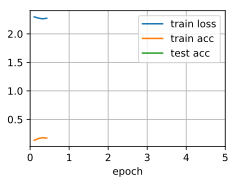

In [ ]:
d2l.train_ch5(net, train_iter, test_iter, num_epochs=5, lr=0.1)